In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(filepath):
    print("--- 1. PREPARING MOMENTUM DATA ---")
    
    df = pd.read_csv(filepath)
    df['waktu_mulai_muat'] = pd.to_datetime(df['waktu_mulai_muat'])
    
    # Hapus periode hantu (Data 0% delay)
    ghost_periods = [
        ('2025-07-07', '2025-07-13'),
        ('2025-08-04', '2025-08-10'),
        ('2025-09-15', '2025-09-21')
    ]
    
    for start, end in ghost_periods:
        mask = (df['waktu_mulai_muat'] >= start) & (df['waktu_mulai_muat'] <= end)
        df = df[~mask]
    
    df = df.sort_values('waktu_mulai_muat').reset_index(drop=True)
    
    return df

In [3]:
def create_momentum_features(df):
    # Target Lag (Apa yang terjadi kemarin?)
    df['lag_1_delay'] = df['label_telat'].shift(1).fillna(0)
    
    # Rolling Mean (Seberapa parah macetnya?)
    # Ini adalah 'Pulse' dari pelabuhan
    # Kita ambil window pendek (10 kapal) dan panjang (50 kapal)
    df['trend_short'] = df['label_telat'].rolling(window=10, min_periods=1).mean().shift(1).fillna(0)
    df['trend_long'] = df['label_telat'].rolling(window=50, min_periods=1).mean().shift(1).fillna(0)
    
    # Delta Trend (Apakah situasi memburuk atau membaik?)
    # Jika Short > Long, berarti kemacetan sedang meningkat pesat
    df['trend_delta'] = df['trend_short'] - df['trend_long']
    
    return df

--- 1. PREPARING MOMENTUM DATA ---

Train Size: 7462 | Test Size: 1866
Delay Rate di Test Set: 83.49%

--- BENCHMARK ---
Naive AUC (Tanpa ML, Cuma pakai rata-rata 10 kapal terakhir): 0.7577

--- MOMENTUM MODEL RESULT ---
ML Momentum AUC: 0.7648
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.24      0.39       308
           1       0.87      1.00      0.93      1558

    accuracy                           0.88      1866
   macro avg       0.93      0.62      0.66      1866
weighted avg       0.89      0.88      0.84      1866



C:\Users\I5\AppData\Local\Temp\ipykernel_11448\2675178567.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = test_df.groupby('trend_bin')['actual'].mean()


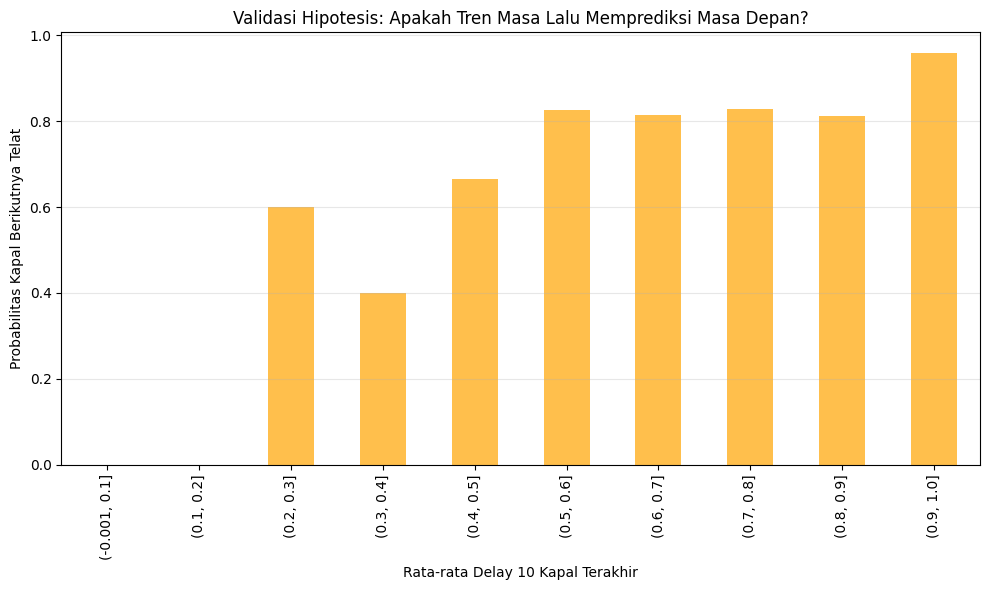

In [6]:
if __name__ == "__main__":
    FILENAME = "../../data/processed/port_loading_risk_10k.csv"
    
    # 1. Prepare
    df = load_data(FILENAME)
    df = create_momentum_features(df)
    
    # HANYA GUNAKAN FITUR TREN (Buang Cuaca, Buang Muatan)
    features = ['trend_short', 'trend_long', 'trend_delta', 'lag_1_delay']
    
    X = df[features].fillna(0)
    y = df['label_telat']
    
    # 2. Split (Time Based 80-20)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"\nTrain Size: {len(X_train)} | Test Size: {len(X_test)}")
    print(f"Delay Rate di Test Set: {y_test.mean():.2%}")
    
    # 3. Baseline Check (Naive Benchmark)
    # Apa jadinya jika kita cuma menebak berdasarkan 'trend_short' tanpa ML?
    # Jika trend_short = 0.8 (80% kapal telat), kita prediksi probabilitas 0.8.
    naive_auc = roc_auc_score(y_test, X_test['trend_short'])
    print(f"\n--- BENCHMARK ---")
    print(f"Naive AUC (Tanpa ML, Cuma pakai rata-rata 10 kapal terakhir): {naive_auc:.4f}")
    
    # 4. Train Simple Model (Logistic Regression)
    # Kenapa LogReg? Karena kita butuh kalibrasi natural, bukan decision tree yang kaku
    model = LogisticRegression(class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    # 5. Predict
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # 6. Final Evaluation
    ml_auc = roc_auc_score(y_test, y_prob)
    print(f"\n--- MOMENTUM MODEL RESULT ---")
    print(f"ML Momentum AUC: {ml_auc:.4f}")
    print("-" * 40)
    print(classification_report(y_test, y_pred))
    
    # 7. Visualisasi Kebenaran
    # Kita plot 'Trend Short' (X) vs 'Actual Delay' (Y)
    # Jika garisnya naik, berarti hipotesis kita benar
    plt.figure(figsize=(10, 6))
    
    # Buat binning trend
    test_df = X_test.copy()
    test_df['actual'] = y_test
    test_df['trend_bin'] = pd.cut(test_df['trend_short'], bins=10)
    
    bin_stats = test_df.groupby('trend_bin')['actual'].mean()
    
    bin_stats.plot(kind='bar', color='orange', alpha=0.7)
    plt.title("Validasi Hipotesis: Apakah Tren Masa Lalu Memprediksi Masa Depan?")
    plt.xlabel("Rata-rata Delay 10 Kapal Terakhir")
    plt.ylabel("Probabilitas Kapal Berikutnya Telat")
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()